Δημιουργήθηκε ένας καμβάς με μέγεθος 300x300


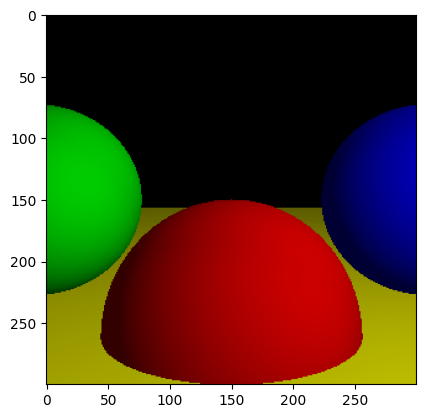

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

class Camera():
  def __init__(self, position, viewport_size, viewport_distance):
    self.position = position
    self.viewport_size = viewport_size
    self.viewport_distance = viewport_distance

class Light():
  def __init__(self, eidos, intensity, position = None, direction = None):
    assert(eidos in ['ambient', 'point', 'directional'])
    assert(intensity > 0.0 and intensity <= 1.0)
    self.eidos = eidos
    self.intensity = intensity
    if(eidos == 'ambient'):
      assert(position is None)
      assert(direction is None)
    elif(eidos == 'point'):
      assert(position is not None)
      assert(direction is None)
    elif(eidos == 'directional'):
      assert(position is None)
      assert(direction is not None)
    self.position = position
    self.direction = direction

class Sphere():
  def __init__(self, center, radius, color):
    assert(radius > 0)
    self.center = center
    self.radius = radius
    self.color = color

class Canvas():   # (σύμβαση: το όνομα του αντικειμένου θα αρχίζει με κεφαλαίο)
  def __init__(self, Ch, Cw):
    # Αυτή η συνάρτηση είναι ο "constructor".
    # Τρέχει αυτόματα με το που δημιουργείται ένα αντικείμενο τύπου "Canvas".
    self.Ch = Ch
    self.Cw = Cw
    self.data = np.zeros([Ch, Cw, 3])
    print(f'Δημιουργήθηκε ένας καμβάς με μέγεθος {Ch}x{Cw}')

  def putPixel(self, Cx, Cy, value):
    # Αυτή η συνάρτηση θα "βάψει" μία συγκεκριμένη θέση (Cx, Cy)
    # στον καμβά (canvas), χρησιμοποιώντας την τιμή "value".
    # Η τιμή value είναι ακέραιος στο 0..255 .
    #
    # Input.
    #   canvas      Πίνακας numpy μεγέθους Ch x Cw.
    #   Cx,Cy       Συντεταγμένες εικονοστοιχείου στο ΣΣ του καμβά. Είναι η θέση που θέλω να βάψω.
    #   value       To χρώμα με το οποίο θα βάψω την παραπάνω θέση.
    #
    # Output.
    #   canvas      Ο τροποποιημένος καμβάς.
    #
    Ch, Cw, _ = self.data.shape
    Si = Ch // 2 - Cy
    Sj = Cw // 2 + Cx
    if(Si >= 0 and Si < Ch and Sj >= 0 and Sj < Cw):
      self.data[Si, Sj, :] = np.uint8(value)

  def show(self):
    plt.imshow(np.uint8(self.data))
    plt.show()



BACKGROUND_COLOR = np.array([0, 0, 0])
sphere_list = [
    Sphere(center = np.array([0, -1, 3]), radius = 1, color = np.array([255, 0, 0])),     # Κόκκινη
    Sphere(center = np.array([2,  0, 4]), radius = 1, color = np.array([0, 0, 255])),     # Μπλε
    Sphere(center = np.array([-2, 0, 4]), radius = 1, color = np.array([0, 255, 0])),     # Πράσινη
    Sphere(center = np.array([0, -5001, 0]), radius = 5000, color = np.array([255, 255, 0])),
]

light_list = [
    Light(eidos = 'ambient', intensity = 0.2),
    Light(eidos = 'point', intensity = 0.6, position = np.array([2, 1, 0])),
    Light(eidos = 'directional', intensity = 0.2, direction = np.array([1, 4, 4]))
]


def canvasToViewport(Cx, Cy, Vw, Vh, Cw, Ch, viewport_distance):
  Vx = Cx*(Vw/Cw)
  Vy = Cy*(Vh/Ch)
  Vz = viewport_distance
  return(np.array([Vx, Vy, Vz]))


def intersectRaySphere(O, D, sphere):
  ###
  # Έλεγχος τομής ακτίνας με αρχικά-τελικά σημεία ΟD και σφαίρας "sphere"
  # Επιστρέφει t1, t2 (συντελεστές που πρέπει να πολλαπλασιάσουν το OD ώστε να πάρουμε
  # την τομή ως τελικό σημείο)
  #
  # Αν δεν υπάρχει τομή, επιστρέφω t1, t2 = +np.inf, +np.inf
  #
  C = sphere.center
  r = sphere.radius
  #color = sphere.color
  CO = O - C
  # Λύση δευτεροβάθμιας εξίσωσης.
  a = np.dot(D, D)
  b = 2*np.dot(CO, D)
  c = np.dot(CO, CO) - r**2
  # Έλεγχος αν η ακτίνα χτυπάει το αντικείμενο
  diakrinousa = b**2 - 4*a*c
  if(diakrinousa < 0):
    return(+np.inf, +np.inf)
  t1 = (-b - np.sqrt(diakrinousa))/(2*a)
  t2 = (-b + np.sqrt(diakrinousa))/(2*a)
  return t1, t2

def computeLighting(P, N):
  # Υπολογίζει σαν αποτέλεσμα ένα συντελεστή
  # που πρέπει να πολλαπλασιαστεί με μια χρωματική τιμή.
  #
  # Είσοδος :
  #       P       Συντεταγμένες του σημείου που με ενδιαφέρει (το σημείο που "χτυπάει" η ακτίνα που εξέπεμψα)
  #       N       Κανονικό διάνυσμα (σημείο κάθετο στην επιφάνεια του αντικειμένου που "χτύπησε" η ακτίνα)
  #
  I = 0.0
  for light in light_list:
    if(light.eidos == 'ambient'):
      I += light.intensity
    else:
      if(light.eidos == 'point'):
        L = light.position - P
      elif(light.eidos == 'directional'):
        L = light.direction
      ######################## END IF
      n_dot_l = np.dot(N, L)
      if(n_dot_l > 0):
        I += light.intensity * n_dot_l / (np.linalg.norm(L) * np.linalg.norm(N))
  ############## END FOR
  if(I > 1.0):
    I = 1.0
  return(I)

def traceRay(O, D, t_min, t_max):
  nearest_t = +np.inf     # Το μέχρι στιγμής μικρότερο t (δηλαδή αντιστοιχεί στην κοντινότερη, αν υπάρχει, τομή)
  nearest_sphere = None
  for sphere in sphere_list:
    t1, t2 = intersectRaySphere(O, D, sphere)
    if(t1 > t_min and t1 < t_max and t1 < nearest_t):
      nearest_t = t1
      nearest_sphere = sphere
    if(t2 > t_min and t2 < t_max and t2 < nearest_t):
      nearest_t = t2
      nearest_sphere = sphere
  ######## end of for loop
  if(nearest_sphere is None):
    return(BACKGROUND_COLOR)
  else:
    P = O + nearest_t*D
    N = P - nearest_sphere.center
    syntelestis = computeLighting(P, N)
    color = np.uint8(nearest_sphere.color * syntelestis)
    return(color)


# Δημιούργησε τον καμβά.
mycanvas = Canvas(Ch = 300, Cw = 300)
# Τοποθέτησε την κάμερα.
mycamera = Camera(position = np.array([0, 0, 0]), viewport_size = np.array([1.0, 1.0]), viewport_distance=1)
for x in range(-mycanvas.Cw//2, +mycanvas.Cw//2):
  for y in range(-mycanvas.Ch//2, +mycanvas.Ch//2):
    # Μετατροπή συντατεγμένων καμβά (Cx,Cy) σε συντεταγμένες στον 3Δ χώρο (VX,VY,VZ)
    D = canvasToViewport(Cx = x, Cy = y, Vw = mycamera.viewport_size[0], Vh = mycamera.viewport_size[1], Cw = mycanvas.Cw, Ch = mycanvas.Ch, viewport_distance=mycamera.viewport_distance)
    # Παρακολούθηση ακτίνας (αρχικό σημείο θέση της κάμερας, τελικό σημείο VΧ,VΥ,VΖ που βρήκα προηγουμένως). Αποτέλεσμα ένα χρώμα
    color = traceRay(mycamera.position, D, t_min = 1, t_max = +np.inf)
    # Βάψε τον καμβά (θέση Cx,Cy) με το χρώμα.
    mycanvas.putPixel(Cx=x, Cy=y, value=color)


mycanvas.show()